In [201]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [203]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [204]:
def evaluate(X, y, weights_with_bias):
    bias = weights_with_bias[0]
    weights = weights_with_bias[1:]
    
    # Calculate predictions using the sigmoid function
    a = np.dot(X, weights) + bias
    y_pred = sigmoid(a)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    
    # Convert predictions to binary (0 or 1)
    y_pred_binary = np.round(y_pred)  # Rounding to 0 or 1

    # Calculate accuracy: how many times the prediction matches the true label
    average_accuracy = np.mean(y_pred_binary == y)
    
    # Calculate cross-entropy loss
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    loss = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))  # Cross-entropy loss for each sample
    average_loss = np.mean(loss)   # Total loss over the entire dataset
    
    return y, y_pred_binary, average_loss, average_accuracy

In [205]:
def train_sgd(X, y, learning_rate, epochs, error_threshold, validation_x, validation_y):
    start_time = time.time()
    weights = np.random.uniform(0, 0.1, X.shape[1] + 1)  # Including bias weight (w₀)
    total_error = float('inf')
    epoch = 0
    
    train_error_log = []
    train_accuracy_log = []
    val_error_log = []
    val_accuracy_log = []

    best_score = -np.inf
    best_weights = weights.copy()
    best_val_accuracy = 0
    best_val_error = float('inf')
    best_epoch = 1
    
    while total_error > error_threshold and epoch < epochs:
        # Shuffle the data
        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        total_error = 0
        total_correct = 0
        for i in range(len(X_shuffled)):
            # Add bias term to input features (X)
            x_i = np.insert(X_shuffled[i], 0, 1)  # Bias input is always 1
            target_label = y_shuffled[i]
            # Calculate the output of the neuron (y_pred)
            a = np.dot(x_i, weights)
            y_pred = sigmoid(a)
            y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
            
            if (y_pred >= 0.5 and target_label == 1) or (y_pred < 0.5 and target_label == 0):
                total_correct += 1
            
            # Update weights (cross entropy gradient descent)
            weights -= learning_rate * (y_pred - target_label) * x_i

            # Calculate cross-entropy loss
            bce = -(target_label * np.log(y_pred) + ((1 - target_label) * np.log(1 - y_pred)))
            total_error += bce
            
        total_error /= len(X_shuffled)
        total_correct /= len(X_shuffled)
        
        train_error_log.append(total_error)
        train_accuracy_log.append(total_correct) 
        
        if validation_x is not None and validation_y is not None:
            _, _, val_error, val_accuracy = evaluate(validation_x, validation_y, weights)
            val_error_log.append(val_error)
            val_accuracy_log.append(val_accuracy)

            score = val_accuracy - val_error

            if score > best_score:
                best_score = score
                best_val_accuracy = val_accuracy
                best_val_error = val_error
                best_weights = weights.copy()
                best_epoch = epoch + 1
            
        epoch += 1
    
    end_time = time.time()
    training_time = end_time - start_time     
        
    return best_weights, best_epoch, train_error_log, train_accuracy_log, val_error_log, val_accuracy_log, training_time

In [206]:
def train_pgd(X, y, learning_rate, epochs, error_threshold, validation_x, validation_y):
    start_time = time.time()
    weights = np.random.uniform(0, 0.1, X.shape[1] + 1) 
    total_error = float('inf')
    epoch = 0
    
    train_error_log = []
    train_accuracy_log = []
    val_error_log = []
    val_accuracy_log = []

    best_score = -np.inf
    best_weights = weights.copy()
    best_val_accuracy = 0
    best_val_error = float('inf')
    best_epoch = 1
    
    while total_error > error_threshold and epoch < epochs:
        # Shuffle the data
        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        gradients = np.zeros_like(weights)
        total_error = 0
        total_correct = 0

        # Iterate over all data points
        for i in range(len(X_shuffled)):
            # Add bias term to input features
            x_i = np.insert(X_shuffled[i], 0, 1)  # Bias input is always 1
            target_label = y_shuffled[i]

            # Calculate the output of the neuron (y_pred)
            a = np.dot(x_i, weights)
            y_pred = sigmoid(a)
            y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)

            # Check for correct prediction
            if (y_pred >= 0.5 and target_label == 1) or (y_pred < 0.5 and target_label == 0):
                total_correct += 1

            # Compute the gradient for the weights for this data point
            gradient = (y_pred - target_label) * x_i
            gradients += gradient

            # Calculate the cross-entropy loss for this example
            bce = -(target_label * np.log(y_pred) + (1 - target_label) * np.log(1 - y_pred))
            total_error += bce

        gradients /= len(X_shuffled)
        weights -= learning_rate * gradients
            
        total_error /= len(X_shuffled)
        total_correct /= len(X_shuffled)
        train_error_log.append(total_error)
        train_accuracy_log.append(total_correct) 
        
        if validation_x is not None and validation_y is not None:
            _, _, val_error, val_accuracy = evaluate(validation_x, validation_y, weights)
            val_error_log.append(val_error)
            val_accuracy_log.append(val_accuracy)

            score = val_accuracy - val_error

            if score > best_score:
                best_score = score
                best_val_accuracy = val_accuracy
                best_val_error = val_error
                best_weights = weights.copy()
                best_epoch = epoch + 1
        
        epoch += 1
    
    end_time = time.time()
    training_time = end_time - start_time    

    return best_weights, best_epoch, train_error_log, train_accuracy_log, val_error_log, val_accuracy_log, training_time

In [207]:
file_path = 'breast-cancer-wisconsin.data'
column_names = [
    "ID", "ClumpThickness", "UniformityOfCellSize", "UniformityOfCellShape", 
    "MarginalAdhesion", "SingleEpithelialCellSize", "BareNuclei", "BlandChromatin", 
    "NormalNucleoli", "Mitoses", "Class"
]

In [208]:
df = pd.read_csv(file_path, names=column_names)
df = df.drop(columns=["ID"])
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)
df['Class'] = df['Class'].map({2: 0, 4: 1})
df = df.sample(frac=1).reset_index(drop=True)
df = df.apply(pd.to_numeric, errors='raise')

benign_count = df[df['Class'] == 0].shape[0]
malignant_count = df[df['Class'] == 1].shape[0]
print(f"Benign data count: {benign_count}")
print(f"Malignant data count: {malignant_count}")


Benign data count: 444
Malignant data count: 239


In [209]:
input_values = df.drop(columns='Class').values
target_labels = df['Class'].values

# Use of stratify to ensure that each subset has the same proportions of each class
train_inputs, temp_inputs, train_targets, temp_targets = train_test_split(input_values, target_labels, test_size=0.2, stratify=target_labels)
val_inputs, test_inputs, val_targets, test_targets = train_test_split(temp_inputs, temp_targets, test_size=0.5, stratify=temp_targets)

print(f"Training data size: {train_inputs.shape[0]} samples")
print(f"Validation data size: {val_inputs.shape[0]} samples")
print(f"Test data size: {test_inputs.shape[0]} samples")

Training data size: 546 samples
Validation data size: 68 samples
Test data size: 69 samples


In [210]:
epoch_count = 100
error_threshold = 0.001
learning_rate = 0.01

In [211]:
sgd_best_weights_with_bias, best_epoch, sgd_error_log, sgd_accuracy_log, sgd_val_error_log, sgd_val_accuracy_log, sgd_training_time = train_sgd(
    train_inputs, train_targets, learning_rate, epoch_count, error_threshold, val_inputs, val_targets)

# Print the weights (including bias) and epoch
print(f"Best Epoch: {best_epoch}")
print(f"Bias: {sgd_best_weights_with_bias[0]:.4f}")
print(f"Weights: {sgd_best_weights_with_bias[1:]}")

# Print errors and accuracies for the last epoch of training and validation data
print(f"Training Error (Last Epoch): {sgd_error_log[-1]:.4f}")
print(f"Training Accuracy (Last Epoch): {sgd_accuracy_log[-1]*100:.2f}%")
print(f"Validation Error (Last Epoch): {sgd_val_error_log[-1]:.4f}")
print(f"Validation Accuracy (Last Epoch): {sgd_val_accuracy_log[-1]*100:.2f}%")

true_test_values, predicted_test_values, average_loss, average_accuracy = evaluate(
    test_inputs, test_targets, sgd_best_weights_with_bias
)

# Print evaluation results for the test set
print("\nTest Set Evaluation:")
print(f"Average Loss: {average_loss:.4f}")
print(f"Average Accuracy: {average_accuracy*100:.2f}%")


df = pd.DataFrame({
    'True Value': true_test_values,
    'Predicted Value': predicted_test_values
})

# Save the DataFrame to an Excel file
excel_filename = 'sgd_test_predictions.xlsx'
df.to_excel(excel_filename, index=False, sheet_name='SGD test predictions')

print(f"Predictions and True Values have been saved to {excel_filename}")

Best Epoch: 71
Bias: -7.6016
Weights: [ 0.28526214  0.12342833  0.33496158  0.2170022  -0.03796196  0.41141275
  0.1683718   0.2072745   0.41957348]
Training Error (Last Epoch): 0.0922
Training Accuracy (Last Epoch): 96.70%
Validation Error (Last Epoch): 0.0913
Validation Accuracy (Last Epoch): 98.53%

Test Set Evaluation:
Average Loss: 0.0973
Average Accuracy: 95.65%
Predictions and True Values have been saved to sgd_test_predictions.xlsx


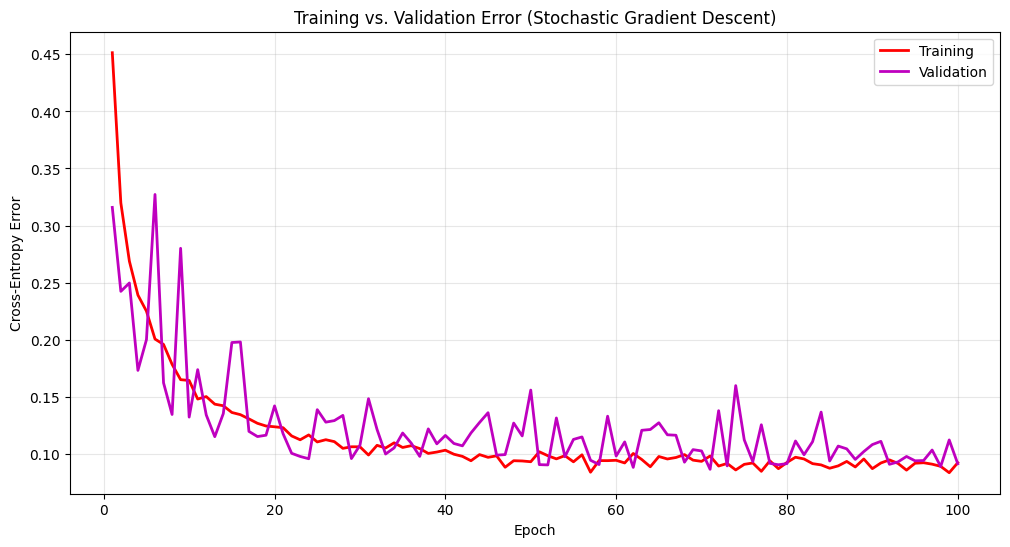

In [212]:
# Define epoch numbers for the x-axis
epochs = range(1, len(sgd_error_log) + 1)

# Set up a wider figure
plt.figure(figsize=(12, 6))
# Plot training and validation error using the epoch values
plt.plot(epochs, sgd_error_log, 'r-', linewidth=2, label='Training')
plt.plot(epochs, sgd_val_error_log, 'm-', linewidth=2, label='Validation')
plt.title('Training vs. Validation Error (Stochastic Gradient Descent)')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


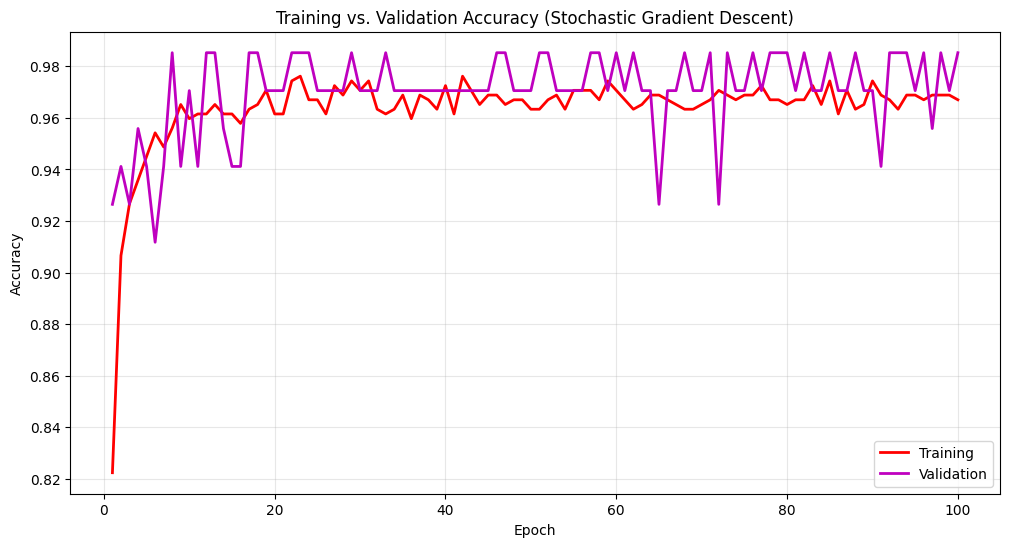

In [213]:
epochs = range(1, len(sgd_error_log) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, sgd_accuracy_log, 'r-', linewidth=2, label='Training')
plt.plot(epochs, sgd_val_accuracy_log, 'm-', linewidth=2, label='Validation')
plt.title('Training vs. Validation Accuracy (Stochastic Gradient Descent)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


--- Training with learning rate: 0.001 ---

--- Training with learning rate: 0.01 ---

--- Training with learning rate: 0.1 ---

--- Training with learning rate: 0.5 ---

--- Training with learning rate: 0.9 ---


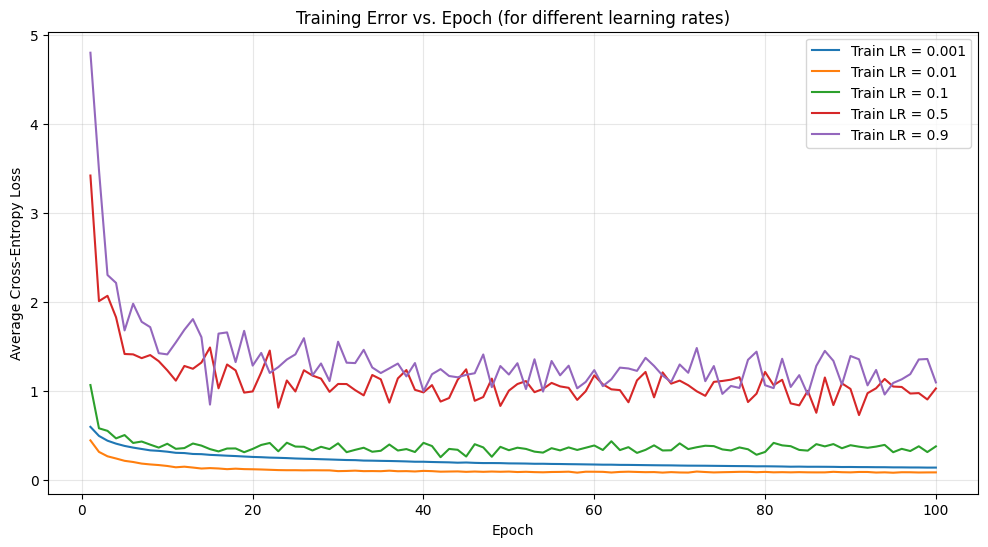

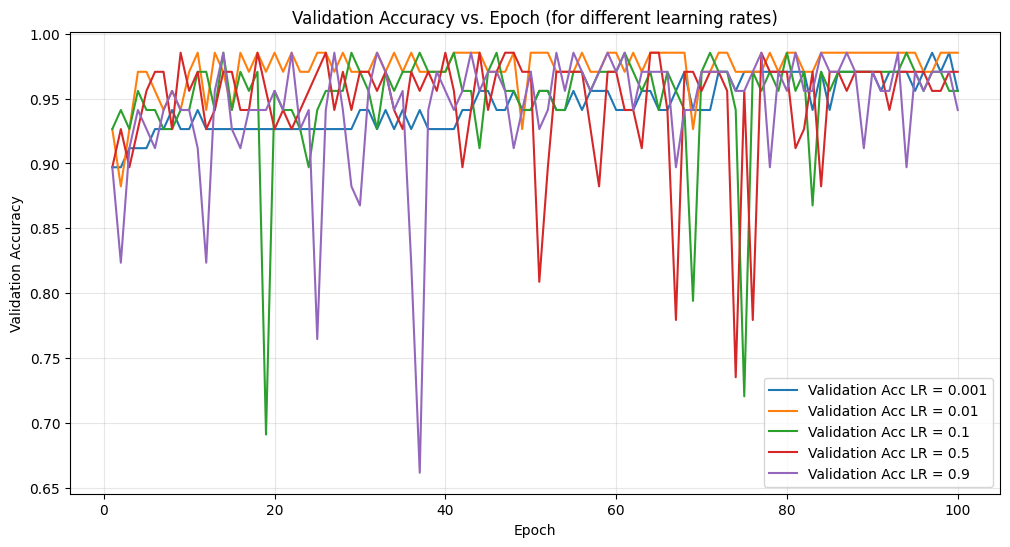

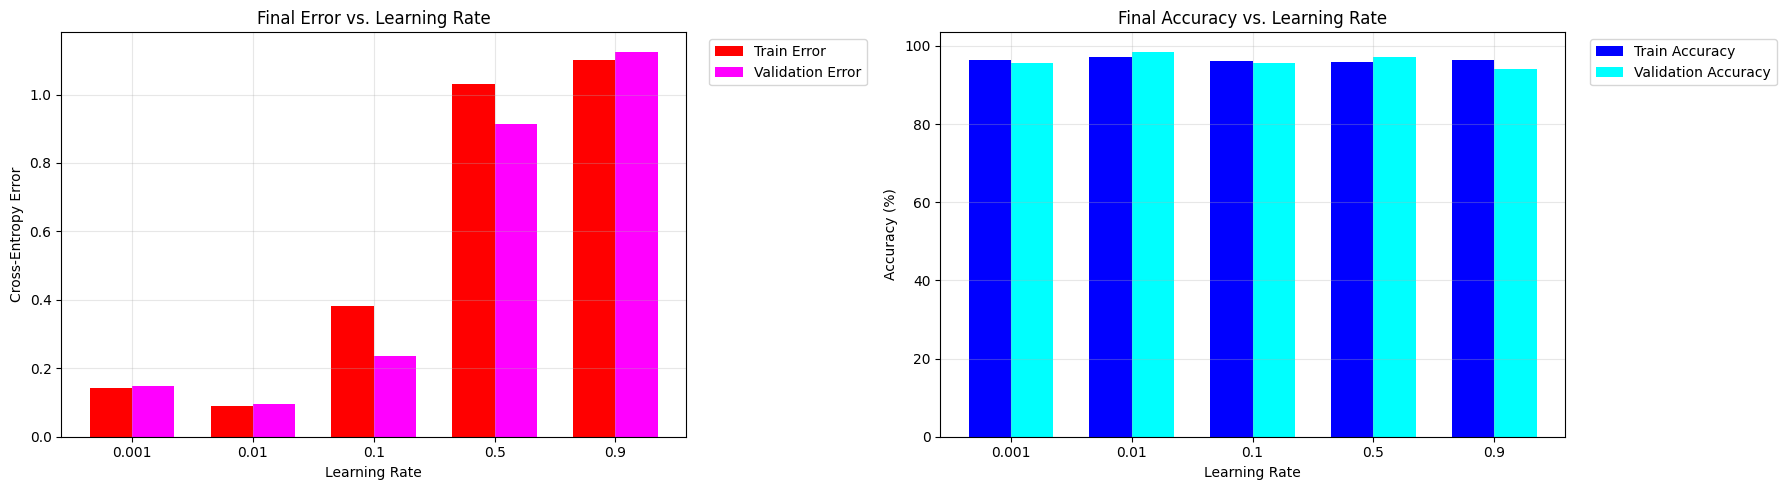

In [214]:
learning_rates = [0.001, 0.01, 0.1, 0.5, 0.9]

results = {}

for lr in learning_rates:
    print(f"\n--- Training with learning rate: {lr} ---")
    _, _, sgd_error_log, sgd_accuracy_log, sgd_val_error_log, sgd_val_accuracy_log, _ = train_sgd(
        train_inputs, train_targets, lr, epoch_count, error_threshold, val_inputs, val_targets
    )
    results[lr] = {
        "train_error_log": sgd_error_log,
        "train_accuracy_log": sgd_accuracy_log,
        "val_error_log": sgd_val_error_log,
        "val_accuracy_log": sgd_val_accuracy_log,
    }
    
# Assuming all experiments used the same number of epochs:
epochs_range = range(1, len(results[learning_rates[0]]["train_error_log"]) + 1)

# Plot Training Error vs. Epoch
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    plt.plot(epochs_range, results[lr]["train_error_log"], label=f"Train LR = {lr}")
plt.title("Training Error vs. Epoch (for different learning rates)")
plt.xlabel("Epoch")
plt.ylabel("Average Cross-Entropy Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot Validation Accuracy vs. Epoch
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    plt.plot(epochs_range, results[lr]["val_accuracy_log"], label=f"Validation Acc LR = {lr}")
plt.title("Validation Accuracy vs. Epoch (for different learning rates)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

train_errors = [results[lr]['train_error_log'][-1] for lr in learning_rates]
val_errors   = [results[lr]['val_error_log'][-1]   for lr in learning_rates]
train_accs   = [results[lr]['train_accuracy_log'][-1] * 100 for lr in learning_rates]
val_accs     = [results[lr]['val_accuracy_log'][-1]   * 100 for lr in learning_rates]

# Set up the x-axis positions for each learning rate
x = np.arange(len(learning_rates))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# --- Subplot 1: Final Error vs. Learning Rate ---\
axs[0].bar(x - width/2, train_errors, width, label='Train Error', color='red')
axs[0].bar(x + width/2, val_errors, width, label='Validation Error', color='magenta')
axs[0].set_xlabel('Learning Rate')
axs[0].set_ylabel('Cross-Entropy Error')
axs[0].set_title('Final Error vs. Learning Rate')
axs[0].set_xticks(x)
axs[0].set_xticklabels([str(lr) for lr in learning_rates])
axs[0].legend(loc='upper right', bbox_to_anchor=(1.3, 1))
axs[0].grid(True, alpha=0.3)

# --- Subplot 2: Final Accuracy vs. Learning Rate ---
axs[1].bar(x - width/2, train_accs, width, label='Train Accuracy', color='blue')
axs[1].bar(x + width/2, val_accs, width, label='Validation Accuracy', color='cyan')
axs[1].set_xlabel('Learning Rate')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Final Accuracy vs. Learning Rate')
axs[1].set_xticks(x)
axs[1].set_xticklabels([str(lr) for lr in learning_rates])
axs[1].legend(loc='upper right', bbox_to_anchor=(1.35, 1))
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [223]:
pgd_best_weights_with_bias, best_epoch, pgd_error_log, pgd_accuracy_log, pgd_val_error_log, pgd_val_accuracy_log, pgd_training_time = train_pgd(
    train_inputs, train_targets, learning_rate, epoch_count, error_threshold, val_inputs, val_targets)

# Print the weights (including bias) and epoch
print(f"Best Epoch: {best_epoch}")
print(f"Bias: {pgd_best_weights_with_bias[0]:.4f}")
print(f"Weights: {pgd_best_weights_with_bias[1:]}")

# Print errors and accuracies for the last epoch of training and validation data
print(f"Training Error (Last Epoch): {pgd_error_log[-1]:.4f}")
print(f"Training Accuracy (Last Epoch): {pgd_accuracy_log[-1]*100:.2f}%")
print(f"Validation Error (Last Epoch): {pgd_val_error_log[-1]:.4f}")
print(f"Validation Accuracy (Last Epoch): {pgd_val_accuracy_log[-1]*100:.2f}%")

true_test_values, predicted_test_values, average_loss, average_accuracy = evaluate(
    test_inputs, test_targets, pgd_best_weights_with_bias
)

# Print evaluation results for the test set
print("\nTest Set Evaluation:")
print(f"Average Loss: {average_loss:.4f}")
print(f"Average Accuracy: {average_accuracy*100:.2f}%")


df = pd.DataFrame({
    'True Value': true_test_values,
    'Predicted Value': predicted_test_values
})

# Save the DataFrame to an Excel file
excel_filename = 'pgd_test_predictions.xlsx'
df.to_excel(excel_filename, index=False, sheet_name='PGD test predictions')

print(f"Predictions and True Values have been saved to {excel_filename}")  

Best Epoch: 100
Bias: -0.1824
Weights: [-0.15213838  0.1358309   0.10059914  0.06797114 -0.12818255  0.2048026
 -0.11027746  0.12625517 -0.06484082]
Training Error (Last Epoch): 0.4672
Training Accuracy (Last Epoch): 88.46%
Validation Error (Last Epoch): 0.4404
Validation Accuracy (Last Epoch): 91.18%

Test Set Evaluation:
Average Loss: 0.4521
Average Accuracy: 88.41%
Predictions and True Values have been saved to pgd_test_predictions.xlsx


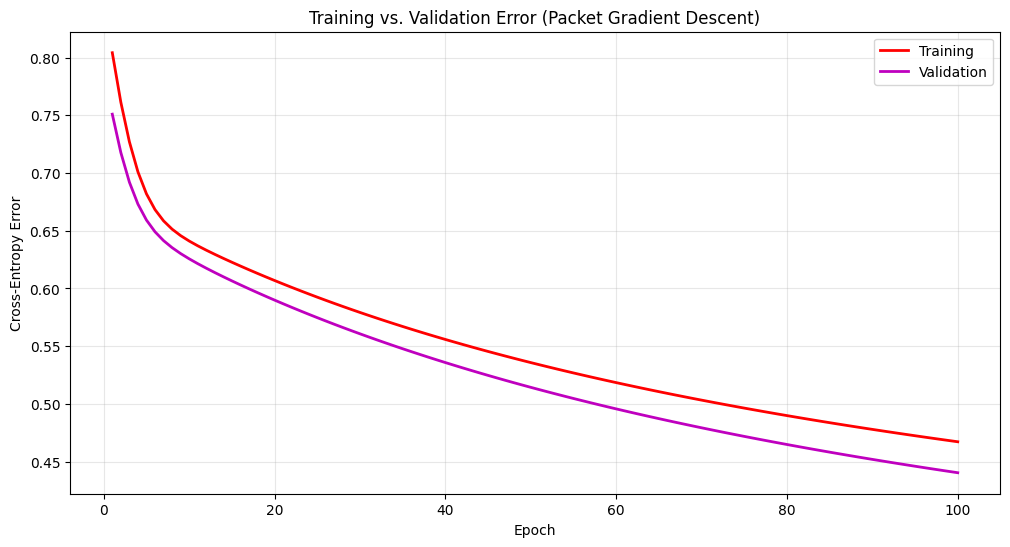

In [224]:
# Define epoch numbers for the x-axis
epochs = range(1, len(pgd_error_log) + 1)

# Set up a wider figure
plt.figure(figsize=(12, 6))
# Plot training and validation error using the epoch values
plt.plot(epochs, pgd_error_log, 'r-', linewidth=2, label='Training')
plt.plot(epochs, pgd_val_error_log, 'm-', linewidth=2, label='Validation')
plt.title('Training vs. Validation Error (Packet Gradient Descent)')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

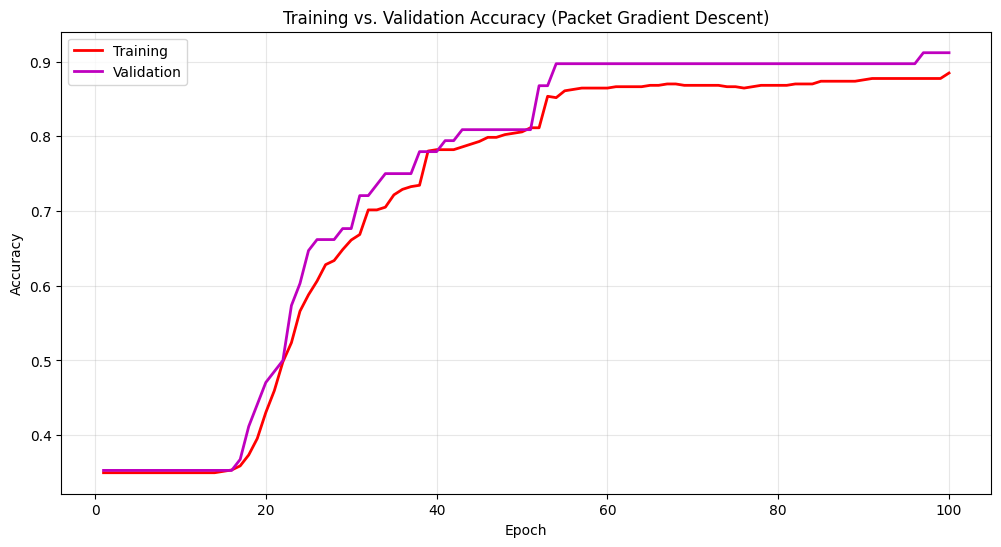

In [225]:
epochs = range(1, len(pgd_error_log) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, pgd_accuracy_log, 'r-', linewidth=2, label='Training')
plt.plot(epochs, pgd_val_accuracy_log, 'm-', linewidth=2, label='Validation')
plt.title('Training vs. Validation Accuracy (Packet Gradient Descent)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


--- Training with learning rate: 0.001 ---

--- Training with learning rate: 0.01 ---

--- Training with learning rate: 0.1 ---

--- Training with learning rate: 0.5 ---

--- Training with learning rate: 0.9 ---


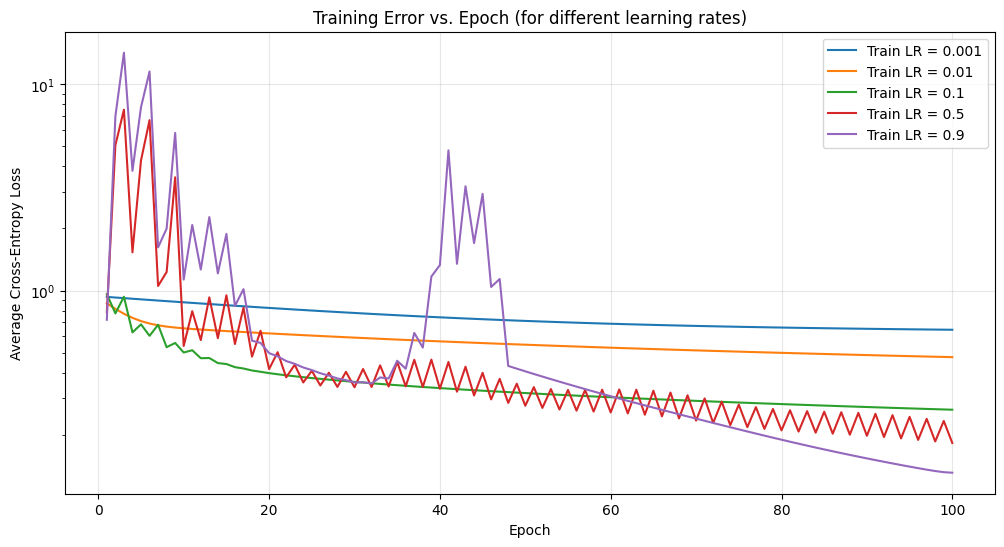

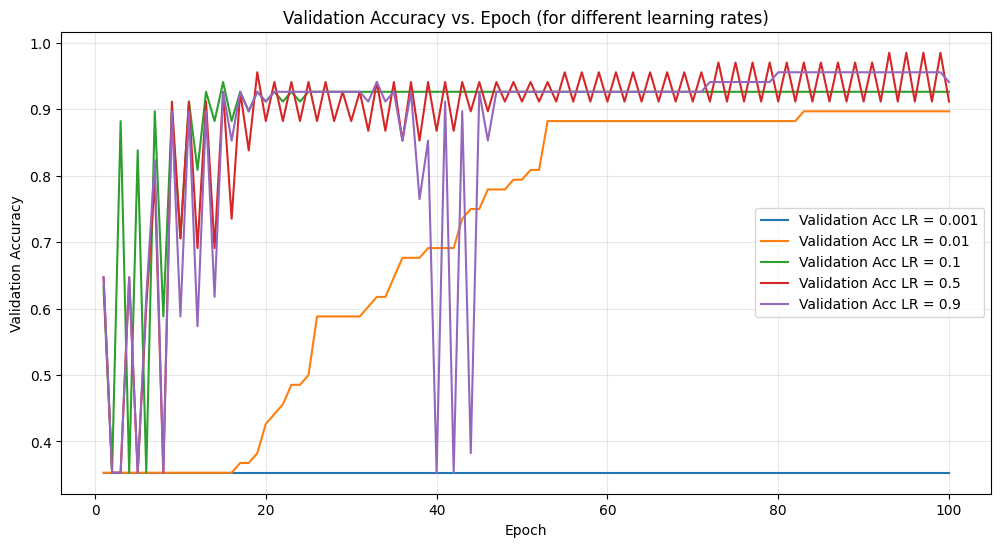

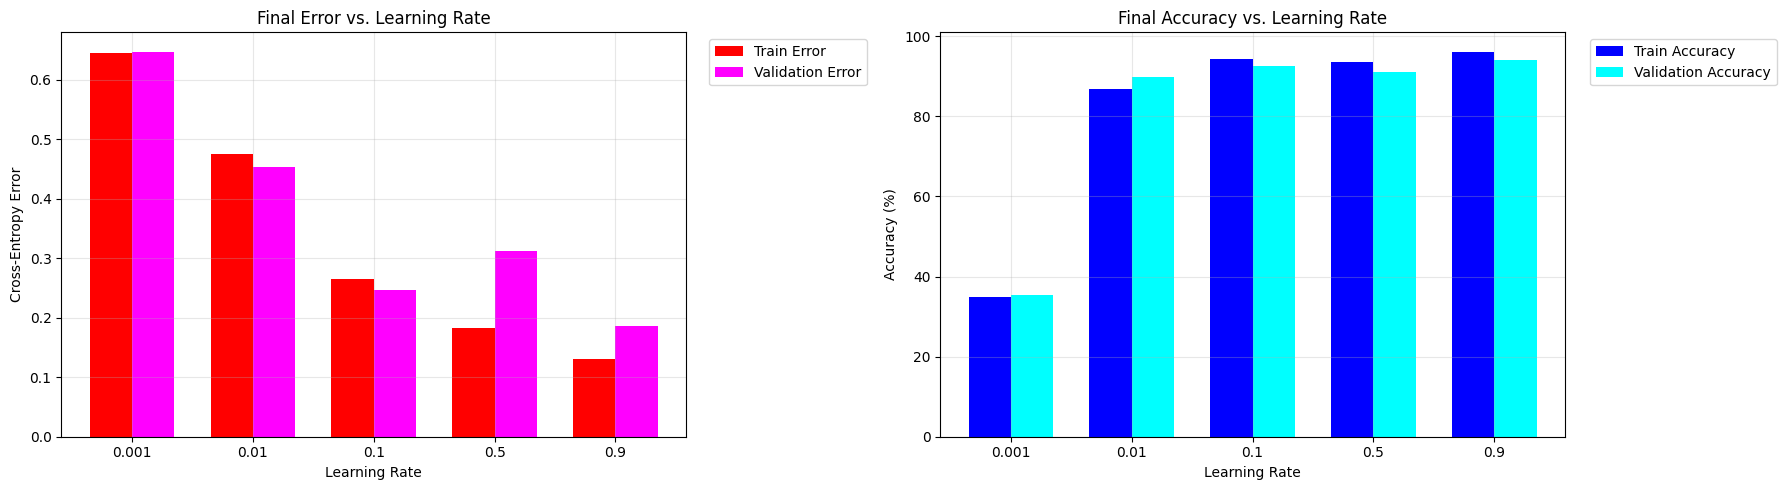

In [226]:
learning_rates = [0.001, 0.01, 0.1, 0.5, 0.9]

results = {}

for lr in learning_rates:
    print(f"\n--- Training with learning rate: {lr} ---")
    _, _, pgd_error_log, pgd_accuracy_log, pgd_val_error_log, pgd_val_accuracy_log, _ = train_pgd(
        train_inputs, train_targets, lr, epoch_count, error_threshold, val_inputs, val_targets
    )
    results[lr] = {
        "train_error_log": pgd_error_log,
        "train_accuracy_log": pgd_accuracy_log,
        "val_error_log": pgd_val_error_log,
        "val_accuracy_log": pgd_val_accuracy_log,
    }
    
# Assuming all experiments used the same number of epochs:
epochs_range = range(1, len(results[learning_rates[0]]["train_error_log"]) + 1)

# Plot Training Error vs. Epoch
plt.figure(figsize=(12, 6))
plt.yscale('log')
for lr in learning_rates:
    plt.plot(epochs_range, results[lr]["train_error_log"], label=f"Train LR = {lr}")
plt.title("Training Error vs. Epoch (for different learning rates)")
plt.xlabel("Epoch")
plt.ylabel("Average Cross-Entropy Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot Validation Accuracy vs. Epoch
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    plt.plot(epochs_range, results[lr]["val_accuracy_log"], label=f"Validation Acc LR = {lr}")
plt.title("Validation Accuracy vs. Epoch (for different learning rates)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

train_errors = [results[lr]['train_error_log'][-1] for lr in learning_rates]
val_errors   = [results[lr]['val_error_log'][-1]   for lr in learning_rates]
train_accs   = [results[lr]['train_accuracy_log'][-1] * 100 for lr in learning_rates]  # convert to percentage
val_accs     = [results[lr]['val_accuracy_log'][-1]   * 100 for lr in learning_rates]

# Set up the x-axis positions for each learning rate
x = np.arange(len(learning_rates))
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# --- Subplot 1: Final Error vs. Learning Rate ---\
axs[0].bar(x - width/2, train_errors, width, label='Train Error', color='red')
axs[0].bar(x + width/2, val_errors, width, label='Validation Error', color='magenta')
axs[0].set_xlabel('Learning Rate')
axs[0].set_ylabel('Cross-Entropy Error')
axs[0].set_title('Final Error vs. Learning Rate')
axs[0].set_xticks(x)
axs[0].set_xticklabels([str(lr) for lr in learning_rates])
axs[0].legend(loc='upper right', bbox_to_anchor=(1.3, 1))
axs[0].grid(True, alpha=0.3)

# --- Subplot 2: Final Accuracy vs. Learning Rate ---
axs[1].bar(x - width/2, train_accs, width, label='Train Accuracy', color='blue')
axs[1].bar(x + width/2, val_accs, width, label='Validation Accuracy', color='cyan')
axs[1].set_xlabel('Learning Rate')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Final Accuracy vs. Learning Rate')
axs[1].set_xticks(x)
axs[1].set_xticklabels([str(lr) for lr in learning_rates])
axs[1].legend(loc='upper right', bbox_to_anchor=(1.35, 1))
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()